# Report mAIstro

Use this notebook for testing [report mAIstro](https://github.com/langchain-ai/report-mAIstro) with Nvidia NIM.


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python langchain_nvidia_ai_endpoints

In [12]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

from langchain_nvidia_ai_endpoints import ChatNVIDIA
tool_models = [model for model in ChatNVIDIA.get_available_models() if model.supports_tools]
print("NVDA tool models:")
print(tool_models)
model_id = "meta/llama-3.1-8b-instruct"
model_id = "meta/llama-3.1-70b-instruct"
llm = ChatNVIDIA(model=model_id, temperature=0)

NVDA tool models:
[Model(id='meta/llama-3.1-8b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None), Model(id='meta/llama-3.1-70b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None), Model(id='meta/llama-3.1-405b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None), Model(id='mistralai/mistral-large-2-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None), Model(id='nv-mistralai/mistral-nemo-12b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None), Model(id='meta/llama-3.2-3b-instruct', model_type='chat', 

We'll use [Tavily API](https://tavily.com/) web search tool.

In [3]:
_set_env("TAVILY_API_KEY")

In [13]:
from tavily import TavilyClient, AsyncTavilyClient
tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [473]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "report-mAIstro"

## Utils

Utility functions that we'll use for web research.

In [5]:
import asyncio
from langsmith import traceable

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research: 
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

@traceable
def tavily_search(query):
    """ Search the web using the Tavily API.
    
    Args:
        query (str): The search query to execute
        
    Returns:
        dict: Tavily search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""
     
    return tavily_client.search(query, 
                         max_results=5, 
                         include_raw_content=True)

@traceable
async def tavily_search_async(search_queries, tavily_topic, tavily_days):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int): Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """
    
    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="news",
                    days=tavily_days
                )
            )
        else:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs

## Flow

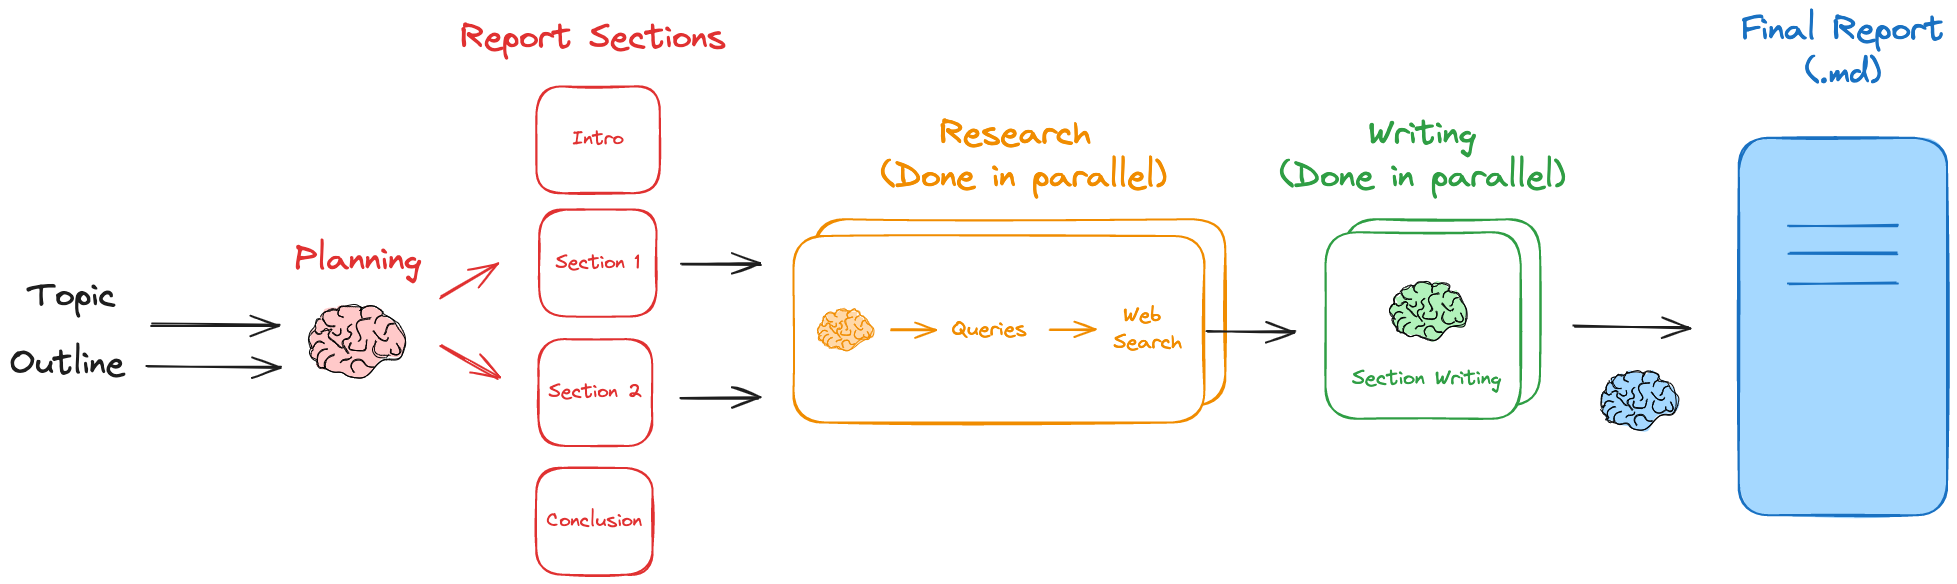


## Planning

Schema for report sections:

In [4]:
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
from pydantic import BaseModel, Field

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )   
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query for web search."
    )
class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

LangGraph state: 

In [14]:
import operator

class ReportState(TypedDict):
    topic: str # Report topic
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    report_structure: str # Report structure
    number_of_queries: int # Number web search queries to perform per section    
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

Generate report sections:

In [15]:
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt to generate a search query to help with planning the report outline
report_planner_query_writer_instructions="""You are an expert technical writer, helping to plan a report. 

The report will be focused on the following topic:

{topic}

The report structure will follow these guidelines:

{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections. 

The query should:

1. Be related to the topic 
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure."""

# Prompt generating the report outline
report_planner_instructions="""You are an expert technical writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report. 

The overall topic of the report is:

{topic}

The report should follow this organization: 

{report_organization}

You should reflect on this information to plan the sections of the report: 

{context}

Now, generate the sections of the report. Each section should have the following fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web research. For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""

async def generate_report_plan(state: ReportState):

    # Inputs
    topic = state["topic"]
    report_structure = state["report_structure"]
    number_of_queries = state["number_of_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Generate search query
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)

    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Web search
    query_list = [query.search_query for query in results.queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=True)

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str)

    # Generate sections 
    structured_llm = llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])

    return {"sections": report_sections.sections}

In [16]:
# Structure
report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)
   
3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

# Topic 
report_topic = "Give an overview of capabilities and specific use case examples for these AI Agent Frameworks: LangGraph, CrewAI."

In [17]:
# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

# Generate report plan
sections = await generate_report_plan({"topic": report_topic, "report_structure": report_structure, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

# Print sections
for section in sections['sections']:
    print(f"{'='*50}")
    print(f"Name: {section.name}")
    print(f"Description: {section.description}")
    print(f"Research: {section.research}")

Name: Introduction
Description: Provide a brief overview of the topic area and context for the comparison of LangGraph and CrewAI AI Agent Frameworks.
Research: False
Name: LangGraph
Description: Examine the core features, architecture and implementation, and provide an example use case for LangGraph.
Research: True
Name: CrewAI
Description: Examine the core features, architecture and implementation, and provide an example use case for CrewAI.
Research: True
Name: Conclusion with Comparison Table
Description: Present a structured comparison table highlighting the relative strengths and weaknesses of LangGraph and CrewAI, and provide final recommendations.
Research: False


## Research + Writing

### Test one section

LangGraph state:

In [18]:
class SectionState(TypedDict):
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    number_of_queries: int # Number web search queries to perform per section 
    section: Section # Report section   
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

Section writing:

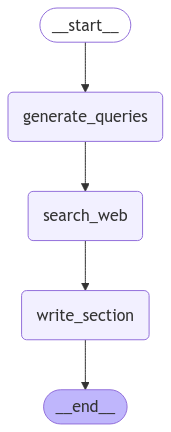

In [19]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

# Query writer instructions
query_writer_instructions="""Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer crafting one section of a technical report.

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material to help write the section:
{context}

5. Quality Checks:
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or list) and only if it helps clarify your point
- One specific example / case study
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end"""

def generate_queries(state: SectionState):
    """ Generate search queries for a section """

    # Get state 
    number_of_queries = state["number_of_queries"]
    section = state["section"]

    # Generate queries 
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    
    # Get state 
    search_queries = state["search_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state 
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Compile
section_builder_graph = section_builder.compile()

# View
display(Image(section_builder_graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
# Test with one section
sections = sections['sections'] 
test_section = sections[1]
print(f"{'='*50}")
print(f"Name: {test_section.name}")
print(f"Description: {test_section.description}")
print(f"Research: {test_section.research}")

# Run
report_section = await section_builder_graph.ainvoke({"section": test_section, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

Name: LangGraph Overview
Description: Detailed exploration of LangGraph, its core features, and how it enables the development of production-ready AI agents
Research: True


In [ ]:
from IPython.display import Markdown
section = report_section['completed_sections'][0]
Markdown(section.content)

### All sections

In [20]:
class ReportStateOutput(TypedDict):
    final_report: str # Final report

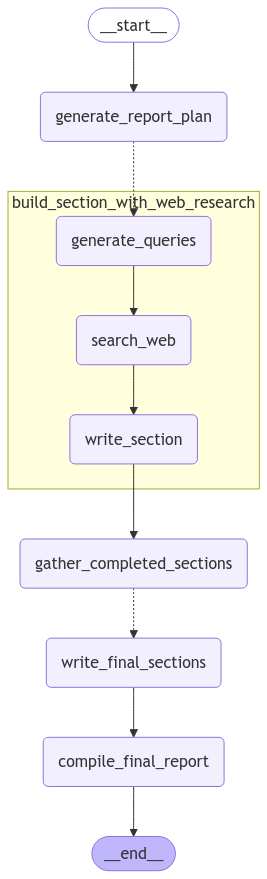

In [21]:
from langgraph.constants import Send

final_section_writer_instructions="""You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Section to write: 
{section_topic}

Available report content:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports: 
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response"""

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """    
    
    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("build_section_with_web_research", {"section": s, 
                                                 "number_of_queries": state["number_of_queries"], 
                                                 "tavily_topic": state["tavily_topic"], 
                                                 "tavily_days": state.get("tavily_days", None)}) 
        for s in state["sections"] 
        if s.research
    ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state 
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ This is the "map" step when we kick off research on any sections that require it using the Send API """    

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Add nodes and edges 
builder = StateGraph(ReportState, output=ReportStateOutput)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [24]:
# Structure
report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)
   
3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

# Topic 
report_topic = "Give an overview of capabilities and specific use case examples for these AI Agent Frameworks: LangGraph, CrewAI."

# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

In [25]:
report = await graph.ainvoke({"topic": report_topic, 
                                   "report_structure": report_structure, 
                                   "number_of_queries": 2, 
                                   "tavily_topic": tavily_topic, 
                                   "tavily_days": tavily_days})

Exception: [500] Internal Server Error
Internal error while making inference request

In [39]:
from IPython.display import Markdown
Markdown(report['final_report'])

# AI Agent Frameworks: Enabling Complex Workflows and Collaboration

AI agent frameworks are revolutionizing the development of advanced artificial intelligence applications. These frameworks provide structured approaches for creating multi-agent systems, enabling AI components to work together on complex tasks. By offering different paradigms for agent interaction and workflow management, frameworks like LangGraph, CrewAI, OpenAI Swarm, and LlamaIndex Workflows are empowering developers to build more sophisticated, flexible, and efficient AI solutions. These tools are critical in addressing the growing demand for AI systems capable of handling intricate, multi-step processes and collaborative problem-solving scenarios in various domains.

## LangGraph: Enabling Complex AI Workflows

**LangGraph's graph-based architecture enables more flexible and controllable AI agent workflows compared to linear frameworks.** Unlike LangChain's sequential chains, LangGraph represents tasks as interconnected nodes in a graph, allowing for non-linear execution paths, cycles, and complex branching logic. This structure is ideal for building multi-agent systems where different AI agents collaborate on tasks.

LangGraph's key components include:
- Nodes: Represent individual tasks or agents
- Edges: Define information flow between nodes
- State: Tracks the current status as data moves through the graph
- Conditional logic: Controls workflow progression

A notable use case is GPT-Newspaper, which leverages LangGraph to coordinate six specialized AI agents in creating personalized news content. The graph structure enables a writer-critique feedback loop, improving output quality.

LangGraph also excels at error handling, allowing failed tasks to be retried or rerouted without restarting the entire workflow. This granular control makes LangGraph well-suited for complex enterprise applications requiring sophisticated decision-making, parallel processing, and human-in-the-loop interactions.

### Sources
- LangGraph: Multi-Agent Workflows - LangChain Blog : https://blog.langchain.dev/langgraph-multi-agent-workflows/
- LangGraph - LangChain : https://www.langchain.com/langgraph
- LangGraph and Research Agents | Pinecone : https://www.pinecone.io/learn/langgraph/

## CrewAI: Orchestrating AI Agent Collaboration

**CrewAI enables structured teamwork between AI agents, enhancing efficiency in complex tasks.** This open-source framework assigns specialized roles to agents, allowing them to work together like a well-coordinated crew. CrewAI's design emphasizes production-readiness and reliability over flexibility, making it ideal for real-world applications.

Key features include:

- Role-based agents with defined expertise
- Sequential task orchestration (with plans for consensual and hierarchical strategies)
- Seamless integration with LangChain for expanded tooling

A practical example demonstrates CrewAI's capabilities in stock analysis:

1. Researcher agent gathers market data
2. Writer agent crafts analysis report

This approach streamlines complex workflows by breaking them into manageable pieces, with each agent contributing its unique skills.

CrewAI's focus on structured collaboration sets it apart from frameworks like AutoGen, which offer more flexibility but potentially less predictability. For developers already familiar with LangChain, CrewAI provides an accessible entry point into multi-agent systems.

While powerful, CrewAI can be resource-intensive. In testing, a simple two-agent interaction consumed $0.18 in API costs, highlighting the need for efficient design in production environments.

### Sources
- Understanding CrewAI: A Deep Dive into Multi-Agent AI Systems : https://medium.com/accredian/understanding-crewai-a-deep-dive-into-multi-agent-ai-systems-110d04703454
- CrewAI: Unlocking Collaborative Intelligence in AI Systems : https://insights.codegpt.co/crewai-guide
- Introduction - CrewAI : https://docs.crewai.com/introduction
- AutoGen Vs CrewAI: A Comprehensive Comparison Of Multi-Agent AI Frameworks : https://dataguy.in/autogen-vs-crewai-multi-agent-ai-framework-comparison/
- I Tested AI Agents Team Using the CrewAI Framework : https://medium.com/timurai/i-tested-ai-agents-team-using-the-crewai-framework-cf02912b84b1

## OpenAI Swarm: A Framework for Multi-Agent Collaboration

**OpenAI Swarm introduces a lightweight, experimental approach to building multi-agent AI systems.** The framework enables developers to create specialized agents that can seamlessly coordinate and hand off tasks. At its core, Swarm utilizes two key concepts: routines, which define an agent's instructions and capabilities, and handoffs, allowing agents to transfer control to others as needed.

A practical example of Swarm in action is an airline customer support system. Multiple agents, including a Triage Agent, Flight Modification Agent, and Lost Baggage Agent, work together to handle diverse customer inquiries. The system routes requests through the Triage Agent, which then transfers control to specialized agents based on the nature of the query.

Swarm's design emphasizes simplicity and transparency, with stateless architecture and direct Python function calls for tool implementation. This approach offers developers fine-grained control over agent behaviors without the overhead of maintaining persistent states. While Swarm is primarily intended for educational purposes, it provides valuable insights into the fundamentals of multi-agent systems and points towards future developments in collaborative AI architectures.

### Sources
- OpenAI Releases Swarm: An Experimental AI Framework for Multi-Agent Systems : https://medium.com/cool-devs/openai-releases-swarm-an-experimental-ai-framework-for-multi-agent-systems-2e2d9372f839
- Swarm: OpenAI's Experimental Approach to Multi-Agent Systems - Arize AI : https://arize.com/blog/swarm-openai-experimental-approach-to-multi-agent-systems/

## LlamaIndex Workflows: Streamlining Complex AI Processes

**LlamaIndex Workflows provide an event-driven abstraction for chaining together multiple AI processes, offering greater flexibility than traditional DAG-based approaches.** This framework allows developers to create sophisticated AI applications by defining steps as Python functions decorated with @step. Each step handles specific event types and can emit new events, enabling dynamic and adaptive processing.

A key advantage is the ability to implement self-correction mechanisms and loops, which are challenging in acyclic graph models. For example, a workflow could include a step that evaluates the quality of an AI-generated response and triggers a refinement process if needed.

LlamaIndex Workflows excel in:

- Multi-stage prompt chaining
- Conditional retrieval based on user input
- Building conversational agents with reinforcement learning

The framework also offers built-in instrumentation for observability, allowing developers to monitor each step's performance using tools like Arize Phoenix. This feature is particularly valuable for debugging complex AI pipelines and optimizing system performance in production environments.

### Sources
- Introducing workflows beta: a new way to create complex AI applications with LlamaIndex : https://www.llamaindex.ai/blog/introducing-workflows-beta
- Understanding LlamaIndex Workflows: Streamlining Complex ... - Medium: https://medium.com/@pankaj_pandey/understanding-llamaindex-workflows-streamlining-complex-processes-easily-ba4c0809a704

## Summary and Recommendations

LangGraph, CrewAI, OpenAI Swarm, and LlamaIndex Workflows each offer unique approaches to multi-agent AI systems. LangGraph's graph-based architecture excels in complex, non-linear workflows, while CrewAI focuses on structured, role-based collaboration. OpenAI Swarm provides a lightweight, experimental framework ideal for educational purposes, and LlamaIndex Workflows offers event-driven flexibility with built-in observability.

| Framework | Key Strength | Best Use Case |
|-----------|--------------|----------------|
| LangGraph | Complex, non-linear workflows | Enterprise applications requiring sophisticated decision-making |
| CrewAI | Structured, role-based collaboration | Production-ready systems with defined agent roles |
| OpenAI Swarm | Simplicity and transparency | Educational projects and prototyping |
| LlamaIndex Workflows | Event-driven flexibility | Applications requiring adaptive processing and self-correction |

For enterprise-level applications with complex decision trees, LangGraph is recommended. CrewAI is ideal for production systems with clearly defined agent roles. Developers exploring multi-agent concepts should consider OpenAI Swarm, while those needing adaptive workflows with strong observability should opt for LlamaIndex Workflows.